In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install jupyter_bbox_widget

In [3]:
import os
import cv2
import torch
import numpy as np
import supervision as sv
from PIL import Image

from detic import Detic
from detic.inference import load_classifier

Loading pretrained CLIP


In [4]:
torch.no_grad().__enter__()

In [5]:
import supervision as sv
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

In [6]:
# helper function that loads an image before adding it to the widget
import io
import base64

def encode_image(im):
    buf = io.BytesIO()
    Image.fromarray(im).save(buf, format='PNG')
    encoded = str(base64.b64encode(buf.getvalue()), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [7]:
model = Detic()

https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth


/home/bea/miniconda3/envs/ptg/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The checkpoint state_dict contains keys that are not used by the model:
  roi_heads.mask_head.mask_fcn1.{bias, weight}
  roi_heads.mask_head.mask_fcn2.{bias, weight}
  roi_heads.mask_head.mask_fcn3.{bias, weight}
  roi_heads.mask_head.mask_fcn4.{bias, weight}
  roi_heads.mask_head.deconv.{bias, weight}
  roi_heads.mask_head.predictor.{bias, weight}


lvis_v1_val Metadata(name='lvis_v1_val', json_file='datasets/lvis/lvis_v1_val.json', image_root='datasets/coco/', evaluator_type='lvis', thing_classes=['aerosol_can', 'air_conditioner', 'airplane', 'alarm_clock', 'alcohol', 'alligator', 'almond', 'ambulance', 'amplifier', 'anklet', 'antenna', 'apple', 'applesauce', 'apricot', 'apron', 'aquarium', 'arctic_(type_of_shoe)', 'armband', 'armchair', 'armoire', 'armor', 'artichoke', 'trash_can', 'ashtray', 'asparagus', 'atomizer', 'avocado', 'award', 'awning', 'ax', 'baboon', 'baby_buggy', 'basketball_backboard', 'backpack', 'handbag', 'suitcase', 'bagel', 'bagpipe', 'baguet', 'bait', 'ball', 'ballet_skirt', 'balloon', 'bamboo', 'banana', 'Band_Aid', 'bandage', 'bandanna', 'banjo', 'banner', 'barbell', 'barge', 'barrel', 'barrette', 'barrow', 'baseball_base', 'baseball', 'baseball_bat', 'baseball_cap', 'baseball_glove', 'basket', 'basketball', 'bass_horn', 'bat_(animal)', 'bath_mat', 'bath_towel', 'bathrobe', 'bathtub', 'batter_(food)', 'batt

In [8]:
lvis_classes, lvis_meta, _ = load_classifier('lvis')
lvis_classes.shape

lvis_v1_val Metadata(name='lvis_v1_val', json_file='datasets/lvis/lvis_v1_val.json', image_root='datasets/coco/', evaluator_type='lvis', thing_classes=['aerosol_can', 'air_conditioner', 'airplane', 'alarm_clock', 'alcohol', 'alligator', 'almond', 'ambulance', 'amplifier', 'anklet', 'antenna', 'apple', 'applesauce', 'apricot', 'apron', 'aquarium', 'arctic_(type_of_shoe)', 'armband', 'armchair', 'armoire', 'armor', 'artichoke', 'trash_can', 'ashtray', 'asparagus', 'atomizer', 'avocado', 'award', 'awning', 'ax', 'baboon', 'baby_buggy', 'basketball_backboard', 'backpack', 'handbag', 'suitcase', 'bagel', 'bagpipe', 'baguet', 'bait', 'ball', 'ballet_skirt', 'balloon', 'bamboo', 'banana', 'Band_Aid', 'bandage', 'bandanna', 'banjo', 'banner', 'barbell', 'barge', 'barrel', 'barrette', 'barrow', 'baseball_base', 'baseball', 'baseball_bat', 'baseball_cap', 'baseball_glove', 'basket', 'basketball', 'bass_horn', 'bat_(animal)', 'bath_mat', 'bath_towel', 'bathrobe', 'bathtub', 'batter_(food)', 'batt

torch.Size([512, 1204])

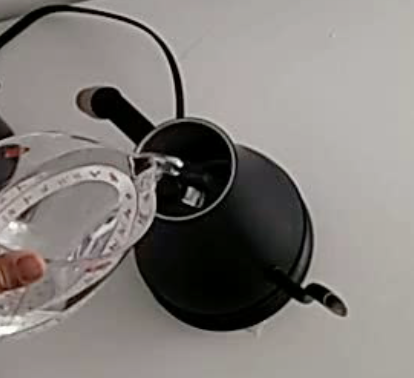

In [9]:
# f = 'measurecup.png'
# f = 'coffee-tools-2.png'
# f = 'tortilla-quesadilla.png'
f = '/datasets/Reference Images/rolled-tortillas-office.png'
f = '/datasets/Reference Images/bowl-empty.png'
f = '/datasets/Reference Images/mug_stack.jpg'
f = '/datasets/Reference Images/kettle_pour.png'
# f = '/datasets/Reference Images/mug_stack2.png'
f = os.path.expanduser(f)
rgb=np.array(Image.open(f))[:,:,:3]
bgr = rgb[:,:,::-1]
Image.fromarray(rgb)

In [10]:
query = model.build_query(rgb)

In [11]:
from jupyter_bbox_widget import BBoxWidget
widget = BBoxWidget()
widget.image = encode_image(rgb)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
gt_boxes = torch.Tensor([
    [d['x'], d['y'], d['width'], d['height']]
    for d in widget.bboxes
])
gt_boxes[:, 2:] += gt_boxes[:, :2]
gt_boxes

tensor([[ 55.,  50., 362., 352.]])

In [43]:
instances = query.predict(gt_boxes.cuda())['instances']
instances._fields

{'pred_boxes': Boxes(tensor([[ 55.0000,  50.0000, 362.0000, 352.0000]], device='cuda:0')),
 'all_scores': tensor([[0.0100, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000]],
        device='cuda:0'),
 'scores': tensor([0.2800], device='cuda:0'),
 'pred_classes': tensor([167], device='cuda:0'),
 'stage_scores': tensor([[[7.9306e-03, 1.2061e-03, 3.1995e-04,  ..., 2.6664e-03,
           1.8066e-04, 5.0000e-01],
          [5.0206e-03, 1.1543e-04, 4.9888e-05,  ..., 4.0019e-04,
           4.3183e-05, 5.0000e-01]]], device='cuda:0'),
 'stage_features': tensor([[[-0.0119,  0.0292,  0.0254,  ..., -0.1156,  0.0393,  0.0343],
          [-0.0076,  0.0258, -0.0235,  ..., -0.1050, -0.0058,  0.0550],
          [-0.0078,  0.0062, -0.0098,  ..., -0.0992, -0.0206,  0.0188]]],
        device='cuda:0')}

In [44]:
model.labels

array(['aerosol_can', 'air_conditioner', 'airplane', ...,
       'yoke_(animal_equipment)', 'zebra', 'zucchini'], dtype='<U45')

In [45]:
scores = instances.all_scores
classes = []
for ii, s in enumerate(scores):
    idx = torch.argsort(s, dim=-1, descending=True).cpu()[:10]
    c = model.labels[idx].tolist()
    classes.extend(c)
    print(f"Bounding Box #{ii}")
    for l, si in zip(model.labels[idx].tolist(), s[idx].tolist()):
        print(f'{l} {si:.1%}')
    print()

Bounding Box #0
bullhorn 28.0%
tambourine 24.0%
measuring_cup 22.0%
fan 19.0%
ladle 18.0%
saucepan 17.0%
strainer 17.0%
teakettle 16.0%
boom_microphone 15.0%
kettle 15.0%



In [ ]:
# for i, h in enumerate(model.predictor.model.roi_heads.box_predictor):
#     h.test_score_thresh = 0.5 #0.001
#     h.cls_score.cls_weight = 0.1
#     h.cls_score.cls_bias = -2

In [ ]:
# features = instances.get('stage_features').mean(1).mean(0, keepdims=True)
# features.shape

In [15]:
classes = np.array([
    # 'jar bottle can',
    # 'jar',
    # 'open jar',
    # 'peanut butter jar',
    # 'peanut butter',
    # 'jelly jar',
    # 'jam jar',
    # 'jar of preserves',
    # 'strawberry jam',
    # # 'cup',
    # 'cup of peanut butter',
    # 'cup of jelly/jam',
    # 'cup',
    # 'mug',
    # # 'tortilla pizza plain circular paper_plate quesadilla pancake',
    # # 'eclair toothpaste popsicle sausage',
    # 'toilet_tissue',
    # 'bowl',
    # 'bowl soup_bowl',
    # 'bowl cup',
    # 'soup_bowl',
    # 'bowl',
    # 'metal',
    # 'cone',
    # 'cup',
    # 'cup vase',
    # 'mug',
    # 'cup vase teacup bowl',
    # 'coffee_filter',
    # 'paper_filter',
    'water_kettle',
    'tea_kettle',
    'teakettle',
    'kettle',
    'boiler',
    'handle',
    'mug',
    'teapot',
    'black teapot',
    'black_teapot_spout',
])
clsf, metadata, _ = load_classifier(classes, classes.tolist(), metadata_name='cls')
del metadata.thing_classes
metadata.thing_classes = classes.tolist()
# clsf, metadata, _ = load_classifier(features, range(len(features)), metadata_name=f'cls{id(features)}')
clsf.shape

cls Metadata(name='cls', thing_colors=[(0.333, 1.0, 0.0), (0.0, 1.0, 0.5), (0.667, 0.667, 0.0), (0.667, 1.0, 1.0), (1.0, 0.667, 0.0), (0.0, 0.0, 0.5), (0.667, 0.333, 1.0), (0.667, 0.0, 1.0)], thing_classes=['water_kettle', 'tea_kettle', 'teakettle', 'kettle', 'boiler', 'handle', 'mug', 'teapot'])


torch.Size([512, 11])

In [16]:
metadata.thing_classes

['water_kettle',
 'tea_kettle',
 'teakettle',
 'kettle',
 'boiler',
 'handle',
 'mug',
 'teapot',
 'black teapot',
 'black_teapot_spout']

[]


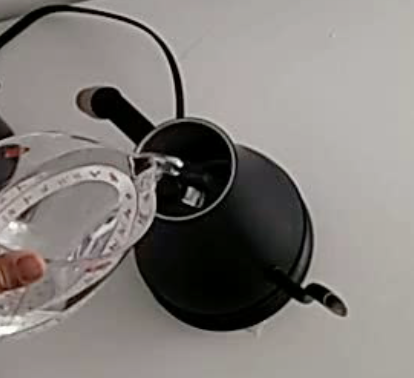

In [17]:
outputs = query.detect(clsf, conf_threshold=0.5, asymmetric_nms=True)

detections = sv.Detections(xyxy=outputs['instances'].pred_boxes.tensor.cpu().numpy())
scores = outputs['instances'].scores
labels = np.array(metadata.thing_classes)[outputs['instances'].pred_classes.int().cpu().numpy()]
labels = [f'{l} ({s:.0%})' for l, s in zip(labels, scores)]
print(labels)
source_image = box_annotator.annotate(scene=rgb[:,:,::-1].copy(), detections=detections, labels=labels)[:,:,::-1]
Image.fromarray(source_image)

In [20]:
ls /datasets/Bridget_videos/mug*

/datasets/Bridget_videos/mug_coffee_kitchen_lightsoff.mp4
/datasets/Bridget_videos/mug_coffee_kithchen_lightson.mp4
/datasets/Bridget_videos/mug_coffee_nursing_lightsoff.mp4
/datasets/Bridget_videos/mug_coffee_nursing_lightson.mp4
/datasets/Bridget_videos/mug_coffee_office_lightsoff.mp4
/datasets/Bridget_videos/mug_coffee_office_lightson.mp4
/datasets/Bridget_videos/mug_coffee_orange_booth_lightsoff.mp4
/datasets/Bridget_videos/mug_coffee_orange_booth_lightson.mp4
/datasets/Bridget_videos/mug_coffee_printer.mp4
/datasets/Bridget_videos/mug_coffee_staircase.mp4
/datasets/Bridget_videos/mug_coffee_window.mp4
/datasets/Bridget_videos/mug_empty_office_lightsoff.MOV
/datasets/Bridget_videos/mug_empty_office_lightson.MOV
/datasets/Bridget_videos/mug_filter_kitchen_lightsoff.mp4
/datasets/Bridget_videos/mug_filter_kitchen_lightson.mp4
/datasets/Bridget_videos/mug_filter_nursing_lightsoff.mp4
/datasets/Bridget_videos/mug_filter_nursing_lightson.mp4
/datasets/Bridget_videos/mug_filter_office_li

In [31]:
from detic.inference import run
run('/datasets/Bridget_videos/mug_filter_kitchen_lightsoff.mp4', classes, model=model)

__vocab:mug,cup vase teacup bowl Metadata(name='__vocab:mug,cup vase teacup bowl', thing_classes=['mug', 'cup vase teacup bowl'], thing_colors=[(1.0, 0.0, 1.0), (0.667, 0.333, 0.0)])
Writing to: /home/bea/ptg/Detic/tools/detic_mug_filter_kitchen_lightsoff.mp4
classes: ['mug' 'cup vase teacup bowl']
using masks: False
single class: True
Input Video /datasets/Bridget_videos/mug_filter_kitchen_lightsoff.mp4
size: (256, 480)  fps: 29.0


1cup vase t: 100%|██████████| 1775/1775 [02:43<00:00, 10.83it/s]     



  _     ._   __/__   _ _  _  _ _/_   Recorded: 08:55:13  Samples:  70349
 /_//_/// /_\ / //_// / //_'/ //     Duration: 163.828   CPU time: 331.051
/   _/                      v4.5.1

Program: /home/bea/.local/lib/python3.10/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"e6fdcb70-d555-421a-8e07-7ef1b9433e54" --shell=9002 --transport="tcp" --iopub=9004 --f=/home/bea/.local/share/jupyter/runtime/kernel-v2-1275855mZckV6rziQNa.json

163.827 run  detic/inference.py:777
├─ 159.134 Detic._call_impl  torch/nn/modules/module.py:1494
│  └─ 159.134 Detic.forward  detic/inference.py:183
│     └─ 159.133 DefaultPredictor.__call__  detic/predictor.py:182
│        ├─ 143.790 CustomRCNN._call_impl  torch/nn/modules/module.py:1494
│        │  └─ 143.788 CustomRCNN.forward  detic/modeling/meta_arch/custom_rcnn.py:156
│        │     └─ 143.767 CustomRCNN.inference  detic/modeling/meta_arch/custom_rcnn.py:8

: 